(ch_ogr_geometries)=
# Geometry operations
In the previous sections, we have learned learned how to [create new vector files](ch_ogr_creations), [how to make selections](ch_ogr_selections), and how to make [coordinate transformations](ch_ogr_CT) using either the entire layer or individual geometries. Now, from your previous experiences in classes that teach GIS you know that one important feature of working with vector objects (regardless of points, lines, polygons) that you can do geometric operations with them.

In this chapter, we present code for the basic operations and visualizations for them. We assume here homogenous coordinate systems in case of operations involving two geometries. If in your personal work this is not the case, you need to think conceptually and [practically](ch_ogr_CT) how you can resolve this issue (e.g., which of the two geometries should be projected?). We start by defining two geometries:

In [ ]:
from osgeo import ogr, osr
import numpy as np
import json
osr.DontUseExceptions()
#

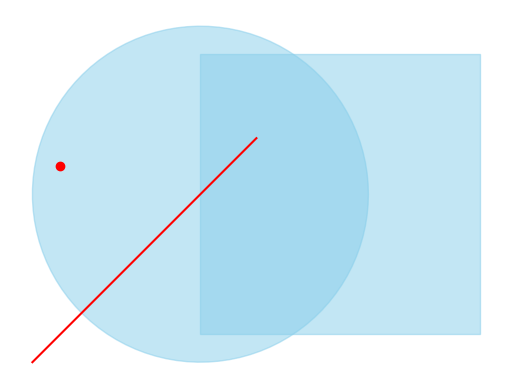

In [237]:
# Create a square geometry
square_ring = ogr.Geometry(ogr.wkbLinearRing)
square_ring.AddPoint(0.5, 0.25)
square_ring.AddPoint(1, 0.25)
square_ring.AddPoint(1, 0.75)
square_ring.AddPoint(0.5, 0.75)
square_ring.AddPoint(0.5, 0.25)
square = ogr.Geometry(ogr.wkbPolygon)
square.AddGeometry(square_ring)

# Make a circle
center_x, center_y = 0.5, 0.5  # Center of the circle
radius = 0.3  # Radius of the circle
num_points = 100  # Number of points to approximate the circle
theta = np.linspace(0, 2 * np.pi, num_points) # Generate points for the circle
x = center_x + radius * np.cos(theta)
y = center_y + radius * np.sin(theta)
ring = ogr.Geometry(ogr.wkbLinearRing) # Create a LinearRing and add the points
for i in range(num_points):
    ring.AddPoint(x[i], y[i])
ring.AddPoint(x[0], y[0])
circle = ogr.Geometry(ogr.wkbPolygon) # Create the polygon from the ring (a circle approximation)
circle.AddGeometry(ring)

# Make a simple point
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(0.25, 0.55)

# Make a simple line
line = ogr.Geometry(ogr.wkbLineString)
line.AddPoint(0.2, 0.2)
line.AddPoint(0.6, 0.6)


# Make coordinates of the square and irregular geometry
square_coords = [(square.GetGeometryRef(0).GetX(i), square.GetGeometryRef(0).GetY(i)) for i in range(square.GetGeometryRef(0).GetPointCount())]
square_x, square_y = zip(*square_coords)
circle_coords = [(circle.GetGeometryRef(0).GetX(i), circle.GetGeometryRef(0).GetY(i)) for i in range(circle.GetGeometryRef(0).GetPointCount())]
circle_x, circle_y = zip(*circle_coords)
point_coords = (point.GetX(), point.GetY())
line_coords = [(line.GetX(i), line.GetY(i)) for i in range(line.GetPointCount())]
line_x, line_y = zip(*line_coords)



# Plot the polygons
plt.fill(square_x, square_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
plt.fill(circle_x, circle_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
plt.plot(point_coords[0], point_coords[1], 'ro')
plt.plot(line_x, line_y, 'r-')

plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes
plt.axis('off')

plt.show()

For completeness purpose, you can see the geometries below:

In [ ]:
# Point
json.loads(point.ExportToJson())

{'type': 'Point', 'coordinates': [0.75, 0.55, 0.0]}

In [ ]:
# Line
json.loads(line.ExportToJson())

{'type': 'LineString', 'coordinates': [[0.2, 0.2, 0.0], [0.6, 0.6, 0.0]]}

In [ ]:
# Square
son.loads(square.ExportToJson())

{'type': 'Polygon',
 'coordinates': [[[0.5, 0.25, 0.0],
   [1.0, 0.25, 0.0],
   [1.0, 0.75, 0.0],
   [0.5, 0.75, 0.0],
   [0.5, 0.25, 0.0]]]}

In [136]:
# Circle
json.loads(circle.ExportToJson())

{'type': 'Polygon',
 'coordinates': [[[0.8, 0.5, 0.0],
   [0.799396002941565, 0.519027175896969, 0.0],
   [0.797586443849239, 0.537977736072125, 0.0],
   [0.794578609178812, 0.556775373308123, 0.0],
   [0.790384610418907, 0.575344396154324, 0.0],
   [0.785021335322284, 0.593610033709546, 0.0],
   [0.778510379904822, 0.611498736698098, 0.0],
   [0.770877961485986, 0.628938473626751, 0.0],
   [0.762154813120935, 0.645859020830141, 0.0],
   [0.752376059849354, 0.662192245236679, 0.0],
   [0.741581077259318, 0.677872378716392, 0.0],
   [0.729813332935693, 0.692836282905962, 0.0],
   [0.717120211431521, 0.707023703444634, 0.0],
   [0.70355282346714, 0.72037751259726, 0.0],
   [0.689165800125357, 0.732843939287527, 0.0],
   [0.674017072871359, 0.744372785615101, 0.0],
   [0.658167640283151, 0.754917628984854, 0.0],
   [0.641681322431805, 0.764436009034275, 0.0],
   [0.624624503900566, 0.772889598606356, 0.0],
   [0.607065866477562, 0.780244358079532, 0.0],
   [0.589076112598482, 0.7864706724

We see different geometries: (1) a sqare, (2) a circle, (3) a line, and (4) a point. Some of tehm overlap, others do not. Now, we can apply operations/comparisons you have learned in your introductory GIS class. If you are uncertain of the different operations, you can can check some of the references provided at the bottom of the page. Let's go one-by-one over the most important operations we will use in our daily work. Again: remember that we make the assumption that the geometries are in the projection. If they weren't any of the operations below would result in an empty result. Likewise, remember that any operations are only executable at the level of geometries. When you e.g., intersect two layers in QGIS, then what the software does under the hood is to iterate over every binary combination of two geometries between the two layers. In python (or any other programing language) we will have to work with ``loops``.

We continue now with two types of comparisons of geometries: (1) we can compare two geometries and test their relationship, (2) we can make operations using two geometries and create a new geometry

## Relationship between geometries
Within ``ogr`` we can ask the following queries to assess the overlap between two geometries. The return value here is always ``True`` or ``False`` depending on the condition. There is a comprehensive collection of operations in the book by Garrard (page 131), here I show the example for the functions ``Intersect()``, ``Within()`` and ``Contains()``. Compare the outcomes to the figure above.


In [240]:
circle.Intersect(square)

True

In [245]:
square.Intersect(point)

False

In [247]:
line.Within(circle)

False

In [248]:
point.Within(circle)

True

In [249]:
circle.Contains(line)

False

In [250]:
circle.Contains(point)

True

One can use these operations to make simple tests. For example, sometimes it is only interesting to ask whether an electricity line goes through a settlement (polygon), but we don't want to create actually a new geometry. In these cases we would would want to use the tests for relationships between geometries. Can you think of other examples?

## Overlay operations
Using overlay operations we do not ask anymore solely for the relationship between two geometries. instead, we are actually creating new geometries. In your introductory GIS class and in other courses you probably have already gained some experience with these types of operations in software environments, such as QGIS or ArcGIS. Here, we take some of these operations and 

### Difference
This operation creates the difference of two geometries. The syntax here (and in other overlay operations) is always ``geom1.Difference(geom2)``. If you look at the two polygons (i..e, the circle and the square), you can see that you can build two ways of differences. One, in which you erase the circle from the square, and one in which you erase the square from the circle. Belo you find an example for both. Can you think of an example where this might be helpful/problematic?

In [283]:
square_diff_circle = square.Difference(circle)

In [285]:
circle_diff_square = circle.Difference(square)

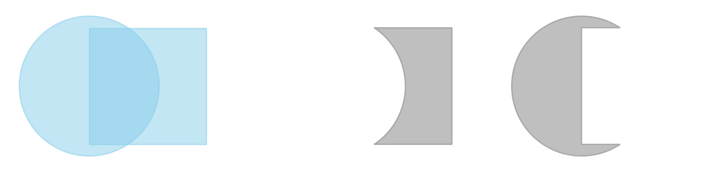

In [297]:
square_diff_coords = []
for i in range(square_diff_circle.GetGeometryRef(0).GetPointCount()):
    square_diff_coords.append((square_diff_circle.GetGeometryRef(0).GetX(i), square_diff_circle.GetGeometryRef(0).GetY(i)))
square_diff_x, square_diff_y = zip(*square_diff_coords)

circle_diff_coords = []
for i in range(circle_diff_square.GetGeometryRef(0).GetPointCount()):
    circle_diff_coords.append((circle_diff_square.GetGeometryRef(0).GetX(i), circle_diff_square.GetGeometryRef(0).GetY(i)))
circle_diff_x, circle_diff_y = zip(*circle_diff_coords)


fig, axes = plt.subplots(1, 3, figsize=(9, 4))
axes[0].fill(square_x, square_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].fill(circle_x, circle_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis('off')


axes[1].fill(circle_x, circle_y, color="skyblue", alpha=0)  # Fill with light blue color and transparency
axes[1].fill(square_diff_x, square_diff_y, color="grey", alpha=0.5)  # Fill with light blue color and transparency
axes[1].set_aspect('equal', adjustable='box')
axes[1].axis('off')

axes[2].fill(square_x, square_y, color="skyblue", alpha=0)  # Fill with light blue color and transparency
axes[2].fill(circle_diff_x, circle_diff_y, color="grey", alpha=0.5)  # Fill with light blue color and transparency
axes[2].set_aspect('equal', adjustable='box')
axes[2].axis('off')


plt.show()

### Intersection
This operation is probably the one you know best. Here, we basically are interested in the overlap of two geometries - and it is not important which geometry is the first and the second in the syntax of the operation:

In [293]:
square_int_circle = square.Intersection(circle)

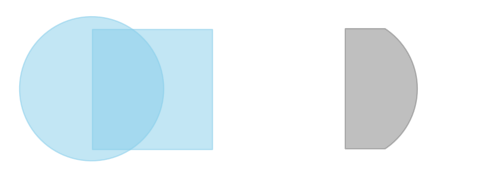

In [300]:
square_int_coords = []
for i in range(square_int_circle.GetGeometryRef(0).GetPointCount()):
    square_int_coords.append((square_int_circle.GetGeometryRef(0).GetX(i), square_int_circle.GetGeometryRef(0).GetY(i)))
square_int_x, square_int_y = zip(*square_int_coords)


fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].fill(square_x, square_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].fill(circle_x, circle_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis('off')

axes[1].fill(square_x, square_y, color="skyblue", alpha=0)
axes[1].fill(circle_x, circle_y, color="skyblue", alpha=0)  # Fill with light blue color and transparency
axes[1].fill(square_int_x, square_int_y, color="grey", alpha=0.5)  # Fill with light blue color and transparency

axes[1].set_aspect('equal', adjustable='box')
axes[1].axis('off')


plt.show()

### Union
The union of two geometries is what you got to know in other contexts as ``dissolve``. Again, the order of the arguments is not important.

In [269]:
square_union_circle = square.Union(circle)

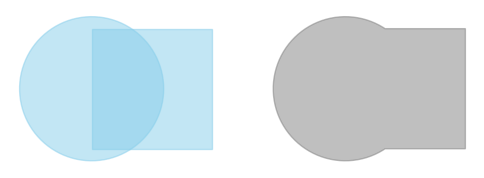

In [270]:
square_union_coords = []
for i in range(square_union_circle.GetGeometryRef(0).GetPointCount()):
    square_union_coords.append((square_union_circle.GetGeometryRef(0).GetX(i), square_union_circle.GetGeometryRef(0).GetY(i)))
square_union_x, square_union_y = zip(*square_union_coords)


fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].fill(square_x, square_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].fill(circle_x, circle_y, color="skyblue", alpha=0.5)  # Fill with light blue color and transparency
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis('off')


axes[1].fill(circle_x, circle_y, color="skyblue", alpha=0)  # Fill with light blue color and transparency
axes[1].fill(square_union_x, square_union_y, color="grey", alpha=0.5)  # Fill with light blue color and transparency

axes[1].set_aspect('equal', adjustable='box')
axes[1].axis('off')


plt.show()

## Other operations
Last but not least, there are a lot of other operations, that we often use. Again, have a look into the book by Garrard for a comprehensive list. Here, we present some of the most frequently used operations

### Buffer
``Buffering`` a geometry basically means that we create a region around a geometry at a specified distance, resulting in a new geometry. The buffer can be applied *expanding*, which means towards the outside of the geometry (points, lines, polygons), or *shrinking*, which means towawrds the inside of the geometry (can only be applied to polygons). The only argument needed is the ``buffer distance``. Here, you need to be careful, as these has to be provided in the units of the underlying coordinate system (e.g., in a UTM coordinate system we have ``m``, in a pseudo-mercator projection we have ``degrees``).

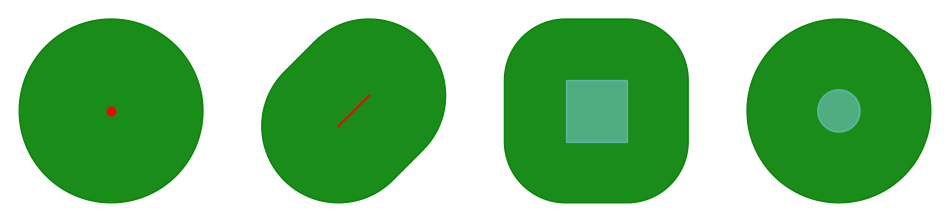

In [200]:
# Build buffers and coordinates
point_buff = point.Buffer(1)
point_buffer_coords = []
for i in range(point_buff.GetGeometryRef(0).GetPointCount()):
    point_buffer_coords.append((point_buff.GetGeometryRef(0).GetX(i), point_buff.GetGeometryRef(0).GetY(i)))
point_buff_x, point_buff_y = zip(*point_buffer_coords)

line_buff = line.Buffer(1)
line_buffer_coords = []
for i in range(line_buff.GetGeometryRef(0).GetPointCount()):
    line_buffer_coords.append((line_buff.GetGeometryRef(0).GetX(i), line_buff.GetGeometryRef(0).GetY(i)))
line_buff_x, line_buff_y = zip(*line_buffer_coords)

square_buff = square.Buffer(0.5)
square_buffer_coords = []
for i in range(square_buff.GetGeometryRef(0).GetPointCount()):
    square_buffer_coords.append((square_buff.GetGeometryRef(0).GetX(i), square_buff.GetGeometryRef(0).GetY(i)))
square_buff_x, square_buff_y = zip(*square_buffer_coords)

circle_buff = circle.Buffer(1)
circle_buffer_coords = []
for i in range(circle_buff.GetGeometryRef(0).GetPointCount()):
    circle_buffer_coords.append((circle_buff.GetGeometryRef(0).GetX(i), circle_buff.GetGeometryRef(0).GetY(i)))
circle_buff_x, circle_buff_y = zip(*circle_buffer_coords)


# Make plot
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].plot(point_coords[0], point_coords[1], 'ro')
axes[0].fill(point_buff_x, point_buff_y, color="green", alpha=0.9)
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis('off')

axes[1].plot(line_x, line_y, 'r-')
axes[1].fill(line_buff_x, line_buff_y, color="green", alpha=0.9)
axes[1].set_aspect('equal', adjustable='box')
axes[1].axis('off')


axes[2].fill(square_buff_x, square_buff_y, color="green", alpha=0.9)
axes[2].fill(square_x, square_y, color="skyblue", alpha=0.5)
axes[2].set_aspect('equal', adjustable='box')
axes[2].axis('off')

axes[3].fill(circle_buff_x, circle_buff_y, color="green", alpha=0.9)
axes[3].fill(circle_x, circle_y, color="skyblue", alpha=0.5)
axes[3].set_aspect('equal', adjustable='box')
axes[3].axis('off')

plt.show()


### Calculate area and/or length
Often, when we have done an overlay operation and have generated a new geometry, we want to assess some properties of this geometry. For example, you have a ``.gpkg`` file of protected areas and you want to calculate the average area or the sum of the areas. Likewise, you may have a ``.gpkg`` file of roads and you want to know how many kilometers of roads are in a certain region. Below are now two examples. The important element to know here is that the output value carries the ``unit`` of the underlying reference system. Thus, when you for example calculate the area of a polygon, make sure that you have the correct projection, so that you calculate the area in m^2 and not in degrees^2. For our example geometries it does not matter at all, bbecause we have not assigned any coordinate reference system to them.


In [252]:
circle.Area()

0.2825535620699948

In [253]:
line.Length()

0.565685424949238

This is all. With this information here and the ones from the previous chapters, you are prepared for the vast majority of vector operations we commonly do in Geography. If you feel something is missing - feel free to drop us a line!
